In [1]:
#import libraries
import time
import numpy as np
import pandas as pd
from scipy.io import loadmat
import csv
from sklearn.cluster import DBSCAN, KMeans
import pyqtgraph as pg
from pyqtgraph.Qt import QtCore, QtGui
%gui qt5

import multiprocessing as mp

import matplotlib.pyplot as plt

### Plotting Setup

In [2]:
#set up plottig GUI
app = QtGui.QApplication([])
pg.setConfigOption('background','w')   

In [3]:
win = pg.GraphicsWindow(title="Occupancy Detection GUI")
plot1 = win.addPlot()
plot1.setXRange(-6,6)
plot1.setYRange(0,6)
plot1.setLabel('left',text = 'Y position (m)')
plot1.setLabel('bottom', text= 'X position (m)')
s1 = plot1.plot([],[],pen=None,symbol='o')
plot2 = win.addPlot()
plot2.setXRange(-6,6)
plot2.setYRange(0,6)
plot2.setLabel('left',text = 'Y position (m)')
plot2.setLabel('bottom', text= 'X position (m)')
s2 = plot2.plot([],[],pen=None,symbol='o')
plot3 = win.addPlot()
plot3.setXRange(-6,6)
plot3.setYRange(0,6)
plot3.setLabel('left',text = 'Y position (m)')
plot3.setLabel('bottom', text= 'X position (m)')
s3 = plot3.plot([],[],pen=None,symbol='o')

#### Parsing Functions

In [4]:
def validateChecksum(recieveHeader):
    h = recieveHeader.view(dtype=np.uint16)
    a = np.array([sum(h)], dtype=np.uint32)
    b = np.array([sum(a.view(dtype=np.uint16))], dtype=np.uint16)
    CS = np.uint16(~(b))
    return CS

def readHeader(recieveHeader):
    headerContent = dict()
    index = 0
    
    headerContent['magicBytes'] = recieveHeader[index:index+8]
    index += 20
    
    headerContent['packetLength'] = recieveHeader[index:index+4].view(dtype=np.uint32)
    index += 4
        
    headerContent['frameNumber'] = recieveHeader[index:index+4].view(dtype=np.uint32)
    index += 24
    
    headerContent['numTLVs'] = recieveHeader[index:index+2].view(dtype=np.uint16)
    
    return headerContent

def tlvParsing(data, dataLength, tlvHeaderLengthInBytes, pointLengthInBytes, targetLengthInBytes):
    
    targetDict = dict()
    pointCloud = None
    index = 0
    #tlv header parsing
    tlvType = data[index:index+4].view(dtype=np.uint32)
    tlvLength = data[index+4:index+8].view(dtype=np.uint32)
    #TLV size check
    if (tlvLength + index > dataLength):
        print('TLV SIZE IS WRONG')
        lostSync = True
        return
    
    index += tlvHeaderLengthInBytes
    pointCloudDataLength = tlvLength - tlvHeaderLengthInBytes
    if tlvType == 6: #point cloud TLV
        numberOfPoints = pointCloudDataLength/pointLengthInBytes
        if numberOfPoints > 0:
            p = data[index:index+pointCloudDataLength[0]].view(dtype=np.single)
            #form the appropriate array 
            #each point is 16 bytes - 4 bytes for each property - range, azimuth, doppler, snr
            pointCloud = np.reshape(p,(4, int(numberOfPoints)),order="F")
    
    return pointCloud

def liveParsing(tlvStream):
    
    tlvHeaderLengthInBytes = 8
    pointLengthInBytes = 16
    frameNumber = 0
    
    tlvStream = np.frombuffer(tlvStream, dtype = 'uint8')
    #tlv header
    index = 0
    #tlv header parsing
    tlvType = tlvStream[index:index+4].view(dtype=np.uint32)
    tlvLength = tlvStream[index+4:index+8].view(dtype=np.uint32)

    index += tlvHeaderLengthInBytes
    tlvDataLength = tlvLength - tlvHeaderLengthInBytes

    if tlvType == 6: 
        numberOfPoints = tlvDataLength/pointLengthInBytes
        p = tlvStream[index:index+tlvDataLength[0]].view(np.single)
        pointCloud = np.reshape(p,(4, int(numberOfPoints)),order="F")

        if not(pointCloud is None):
            #constrain point cloud to within the effective sensor range
            #range 1 < x < 6
            #azimuth -50 deg to 50 deg
            #check whether corresponding range and azimuth data are within the constraints

            effectivePointCloud = np.array([])
            for index in range(0, len(pointCloud[0,:])):
                if (pointCloud[0,index] > 1 and pointCloud[0,index] < 6) \
                and (pointCloud[1, index] > -50*np.pi/180 \
                    and pointCloud[1, index] < 50*np.pi/180):

                    #concatenate columns to the new point cloud
                    if len(effectivePointCloud) == 0:
                        effectivePointCloud = np.reshape(pointCloud[:, index], (4,1), order="F")
                    else:
                        point = np.reshape(pointCloud[:, index], (4,1),order="F")
                        effectivePointCloud = np.hstack((effectivePointCloud, point))

            if len(effectivePointCloud) != 0:
                posX = np.multiply(effectivePointCloud[0,:], np.sin(effectivePointCloud[1,:]))
                posY = np.multiply(effectivePointCloud[0,:], np.cos(effectivePointCloud[1,:]))
                SNR  = effectivePointCloud[3,:]
                return posX, posY, SNR
            
    return None, None, None

#### Clustering Functions

In [5]:
def iterativeDfs(vertexID, edgeMatrix, startNode):
    
    visited = np.array([], dtype=np.int)
    dfsStack = np.array([startNode])

    while np.logical_not(np.equal(dfsStack.size,0)):
        vertex, dfsStack = dfsStack[-1], dfsStack[:-1] #equivalent to stack pop function
        if vertex not in visited:
            #find unvisited nodes
            unvisitedNodes = vertexID[np.logical_not(np.isnan(edgeMatrix[int(vertex), :]))]
            visited = np.append(visited, vertex)
            #add unvisited nodes to the stack
            dfsStack = np.append(dfsStack, unvisitedNodes[np.logical_not(np.isin(unvisitedNodes,visited))])
    
    return visited

In [6]:
def CombinationClustering(posX, posY, SNR):
    weightThreshold = 0.8 #minimum distance between points
    minClusterSize = 3
    
    vertexID = np.arange(len(posX))
    vertexList = np.arange(len(posX))
    
    xMean = np.array([])
    yMean = np.array([])

    if len(posX) >= minClusterSize:
        edgeMatrix = np.zeros((len(posX), len(posY)))

        #create distance matrix
        #x1 - x0
        xDifference = np.subtract(np.repeat(posX, repeats=len(posX)).reshape(len(posX), len(posX)), 
                                  np.transpose(np.repeat(posX, repeats=len(posX)).reshape(len(posX), len(posX))))
        #y1 - y0
        yDifference = np.subtract(np.repeat(posY, repeats=len(posY)).reshape(len(posY), len(posY)), 
                                  np.transpose(np.repeat(posY, repeats=len(posY)).reshape(len(posY), len(posY))))
        #euclidean distance calculation
        edgeMatrix = np.sqrt(np.add(np.square(xDifference), np.square(yDifference)))

        #weight based reduction of graph/remove edges by replacing edge weight by np.NaN
        weightMask = np.logical_or(np.greater(edgeMatrix,weightThreshold), np.equal(edgeMatrix, 0))
        edgeMatrix[weightMask] = np.NaN

        #perform iterative dfs
        pointsX = np.array([])
        pointsY = np.array([])

        centroidNumber = 0
        while vertexID.size > 0:
            startNode = vertexID[0]
            visited = iterativeDfs(vertexList, edgeMatrix, startNode)
            #remove visited nodes (ie only slice off all unvisited nodes)
            vertexID = vertexID[np.logical_not(np.isin(vertexID, visited))]
            #visited is a component, extract cluster from it if possible
            if visited.size >= minClusterSize:
                pointsX = np.append(pointsX, posX[visited])
                pointsY = np.append(pointsY, posY[visited]) 

        if pointsX.size > 0:
            clusterer = DBSCAN(eps=1, min_samples=5)
            clusterer.fit(pd.DataFrame(np.transpose(np.array([pointsX,pointsY]))).values)

            if clusterer.core_sample_indices_.size > 0:
                #array that contains the x,y positions and the cluster association number
                clusters = np.array([pointsX[clusterer.core_sample_indices_],
                          pointsY[clusterer.core_sample_indices_], 
                         clusterer.labels_[clusterer.core_sample_indices_]])
                for centroidNumber in np.unique(clusters[2,:]):
                    xMean = np.append(xMean, np.mean(clusters[0,:][np.isin(clusters[2,:], centroidNumber)]))
                    yMean = np.append(yMean, np.mean(clusters[1,:][np.isin(clusters[2,:], centroidNumber)]))
    return yMean, xMean

In [7]:
def DBSCANOnlyClusteringWeightedSum(pointsX, pointsY):
    
    #initialize constraints/variables
    minClusterSize = 1
    xMean = np.array([])
    yMean = np.array([])
    
    if len(pointsX) >= minClusterSize:

        clusterer = DBSCAN(eps=1, min_samples=5)
        
        clusterer.fit(pd.DataFrame(np.transpose(np.array([pointsX,pointsY]))).values)

        if clusterer.core_sample_indices_.size > 0:
            #array that contains the x,y positions and the cluster association number
            clusters = np.array([pointsX[clusterer.core_sample_indices_],
                      pointsY[clusterer.core_sample_indices_], 
                     clusterer.labels_[clusterer.core_sample_indices_]])
            for centroidNumber in np.unique(clusters[2,:]):
                xMean = np.append(xMean, np.mean(clusters[0,:][np.isin(clusters[2,:], centroidNumber)]))
                yMean = np.append(yMean, np.mean(clusters[1,:][np.isin(clusters[2,:], centroidNumber)]))
                


    return yMean, xMean

In [8]:
def DBSCANOnly(pointsX, pointsY):
    
    #initialize constraints/variables
    minClusterSize = 1
    xMean = np.array([])
    yMean = np.array([])
    
    if len(pointsX) >= minClusterSize:

        clusterer = DBSCAN(eps=1, min_samples=5)
        
        clusterer.fit(pd.DataFrame(np.transpose(np.array([pointsX,pointsY]))).values)

        if clusterer.core_sample_indices_.size > 0:
            #array that contains the x,y positions and the cluster association number
            clusters = np.array([pointsX[clusterer.core_sample_indices_],
                      pointsY[clusterer.core_sample_indices_], 
                     clusterer.labels_[clusterer.core_sample_indices_]])
                
            

    return clusters

In [128]:
def TreeClusteringOnly(posX, posY, SNR):
    weightThreshold = 1 #minimum distance between points
    minClusterSize = 15
    
    vertexID = np.arange(len(posX))
    vertexList = np.arange(len(posX))
    
    xMean = np.array([])
    yMean = np.array([])

    if len(posX) >= minClusterSize:
        edgeMatrix = np.zeros((len(posX), len(posY)))

        #create distance matrix
        #x1 - x0
        xDifference = np.subtract(np.repeat(posX, repeats=len(posX)).reshape(len(posX), len(posX)), 
                                  np.transpose(np.repeat(posX, repeats=len(posX)).reshape(len(posX), len(posX))))
        #y1 - y0
        yDifference = np.subtract(np.repeat(posY, repeats=len(posY)).reshape(len(posY), len(posY)), 
                                  np.transpose(np.repeat(posY, repeats=len(posY)).reshape(len(posY), len(posY))))
        #euclidean distance calculation
        edgeMatrix = np.sqrt(np.add(np.square(xDifference), np.square(yDifference)))

        #weight based reduction of graph/remove edges by replacing edge weight by np.NaN
        weightMask = np.logical_or(np.greater(edgeMatrix,weightThreshold), np.equal(edgeMatrix, 0))
        edgeMatrix[weightMask] = np.NaN

        #perform iterative dfs
        associatedPoints = np.array([])
        
        
        centroidNumber = 0
        asscociatedPoints = np.array([])
        while vertexID.size > 0:
            startNode = vertexID[0]
            visited = iterativeDfs(vertexList, edgeMatrix, startNode)
            #remove visited nodes (ie only slice off all unvisited nodes)
            vertexID = vertexID[np.logical_not(np.isin(vertexID, visited))]
#             #visited is a component, extract cluster from it if possible
            if visited.size >= minClusterSize:
                cluster =  np.array([posX[visited], posY[visited],SNR[visited],
                                     np.repeat(centroidNumber, repeats=len(visited))])
                if asscociatedPoints.size == 0:
                    asscociatedPoints = cluster
                else:
                    asscociatedPoints = np.hstack((asscociatedPoints, cluster))
                centroidNumber += 1
                                    
                


        return asscociatedPoints

#### Tracking Functions

In [10]:
def predict(x, P, A, Q): #predict function
    xpred = np.matmul(A,x)
    Ppred = np.matmul(A,P)
    Ppred = np.matmul(Ppred,np.transpose(A)) + Q
    return(xpred, Ppred)

def innovation(xpred, Ppred, z, H, R): #innovation function
    nu = z - np.matmul(H,xpred)
    S = np.matmul(H,Ppred)
    S = R + np.matmul(S, np.transpose(H))
    return(nu, S)

def innovation_update(xpred, Ppred, nu, S, H):
    K = np.matmul(Ppred, np.transpose(H))
    K = np.matmul(K,np.linalg.inv(S)) #check inverse function
    xnew = xpred + np.matmul(K,nu)
    Pnew = np.matmul(K,S)
    Pnew = Ppred - np.matmul(Pnew,np.transpose(K)) 
    return(xnew, Pnew)

def cart2pol(x, y):
    rho = np.sqrt(x**2 + y**2)
    phi = np.arctan2(y, x)
    return(rho, phi)

def data_associate(centroidPred, rthetacentroid):
    rthetacentroidCurrent = rthetacentroid
    centpredCol = np.size(centroidPred,1)
    rthetaCol = np.size(rthetacentroid,1)

    for i in list(range(0,centpredCol)):
        r1 = centroidPred[0][i]
        r2 = rthetacentroid[0]
        theta1 = centroidPred[2][i]
        theta2 = rthetacentroid[1]
        temp = np.sqrt(np.multiply(r1,r1) + np.multiply(r2,r2) - np.multiply(np.multiply(np.multiply(2,r1),r2),np.cos(theta2-theta1)))
        if(i==0):
            minDist = temp
        else:
            minDist = np.vstack((minDist,temp))

    currentFrame = np.empty((2,max(centpredCol,rthetaCol)))
    currentFrame[:] = np.nan

    minDist = np.reshape(minDist, (centpredCol,rthetaCol))
    minDistOrg = minDist

    for i in list(range(0,min(centpredCol,rthetaCol))):
        if((np.ndim(minDist)) == 1):
            minDist = np.reshape(minDist,(rthetaCol,1))
            minDistOrg = np.reshape(minDistOrg,(rthetaCol,1))
        val = np.min(minDist)
        resultOrg = np.argwhere(minDistOrg == val)
        result = np.argwhere(minDist == val)
        minRowOrg = resultOrg[0][0]
        minColOrg = resultOrg[0][1]
        minRow = result[0][0]
        minCol = result[0][1]
        currentFrame[:,minRowOrg] = rthetacentroid[:,minColOrg]
        minDist = np.delete(minDist,minRow,0)
        minDist = np.delete(minDist,minCol,1)
        rthetacentroidCurrent = np.delete(rthetacentroidCurrent,minCol,1)

    index = 0
    if (rthetacentroidCurrent.size != 0): #check indexing
        for i in list(range(centpredCol,rthetaCol)):
            currentFrame[:,i] = rthetacentroidCurrent[:,index]
            index += 1 

    return(currentFrame)

def LiveRKF(currentrawxycentroidData, centroidX, centroidP):
    
    #initialise matrices 
    delT = 0.0500
    A = np.array([[1,delT,0,0], 
                  [0,1,0,0], 
                  [0,0,1,delT], 
                  [0,0,0,1]])
    H = np.array([[1,0,0,0],
                  [0,0,1,0]])
    P = np.identity(4)
    Q = np.multiply(0.9,np.identity(4))
    R = np.array([[1],[1]])

    xytransposecentroidData = currentrawxycentroidData
    rthetacentroidData=xytransposecentroidData
    if (xytransposecentroidData.size != 0): 
        [rthetacentroidData[0,:],rthetacentroidData[1,:]] = cart2pol(xytransposecentroidData[0,:],xytransposecentroidData[1,:])
    if((rthetacentroidData.size != 0)):
        currentFrame = data_associate(centroidX, rthetacentroidData)
        addittionalCentroids = (np.size(rthetacentroidData,1)-np.size(centroidX,1))
        if(addittionalCentroids>0):
            centroidX = np.pad(centroidX, ((0,0),(0,addittionalCentroids)), 'constant') #initialises previous iteration to zer
            for newFrameIndex in list((range(0, addittionalCentroids))):
                centroidP.extend([P])
        for currentFrameIndex in list((range(0,np.size(currentFrame,1)))):
            if(not(np.isnan(currentFrame[0,currentFrameIndex]))):
                [xpred, Ppred] = predict(centroidX[:,currentFrameIndex], centroidP[currentFrameIndex], A, Q)
                [nu, S] = innovation(xpred, Ppred, currentFrame[:, currentFrameIndex], H, R)
                [centroidX[:,currentFrameIndex],  centroidP[currentFrameIndex]] = innovation_update(xpred, Ppred, nu, S, H)
            else:
                [centroidX[:,currentFrameIndex], centroidP[currentFrameIndex]] = predict(centroidX[:,currentFrameIndex], centroidP[currentFrameIndex], A, Q)                   
    else:
        for noFrameIndex in list((range(0,np.size(centroidX,1)))):
            [centroidX[:,noFrameIndex], centroidP[noFrameIndex]] = predict(centroidX[:,noFrameIndex], centroidP[noFrameIndex], A, Q)
            
    #centroidX is 4xN array that contains that centroid information for that frame
    return centroidX, centroidP


#### Offline Code

In [130]:
# parsingMatFile = 'C:\\Users\\hasna\\Documents\\GitHub\\OccupancyDetection\\Data\\Experiment Data 2\\1PersonWalkingLocationDhari.mat'
parsingMatFile = 'C:\\Users\\hasna\\Documents\\GitHub\\OccupancyDetection\\Data\\Matlab Data\\fastWalk.mat'

tlvData = (loadmat(parsingMatFile))['tlvStream'][0]

centroidX =np.zeros((4,1))
centroidP = []
P = np.identity(4);
centroidP.extend([P])

snrThreshold = 20
numberOfSucessfulClusters = 0

for tlvStream in tlvData:
    #parse
    posX, posY, SNR = liveParsing(tlvStream)

    try:
        if (posX == None).all():
            continue
    except AttributeError:
        continue
    
    #tree based clustering
    clusters = TreeClusteringOnly(posX, posY, SNR)
    if clusters is not None and clusters.size > 0:
        #where Row 0 - X
        #Row 1 - Y
        #Row 2 - SNR 
        #Row 3 - Cluster Identifier (just an integer to distinguish points associated to different clusters)
        s1.setData(posX, posY)
        s2.setData(clusters[0,:], clusters[1,:])

        #SNR testing - remove weak points
        snrMask = np.greater(clusters[2,:], snrThreshold)
        filteredClusters = clusters[:,snrMask]
        if filteredClusters[3,:].size > 0:
            s3.setData(filteredClusters[0,:], filteredClusters[1,:])
            print(max(filteredClusters[3,:]))
        else:
            s3.setData([], [])
        QtGui.QApplication.processEvents() 
        time.sleep(0.05)

#     #SNR testing - remove weak points
#     snrMask = np.greater(SNR, snrThreshold)
#     snrX = posX[snrMask]
#     snrY = posY[snrMask]
    
#     s1.setData(posX,posY)
#     s2.setData(snrX,snrY)
#     yMean, xMean  = CombinationClustering(snrX, snrY)
#     if yMean.size > 1:
#         print('HALT')
#         break
# #     print(yMean, xMean)
#     s3.setData(xMean, yMean)
#     QtGui.QApplication.processEvents() 
#     time.sleep(0.05)
    
        
#     #cluster
#     yMean, xMean = CombinationClustering(posX, posY)
    
#     centroidData = np.array([xMean, yMean])
#     #track
#     centroidX, centroidP = LiveRKF(centroidData, centroidX, centroidP)
#     #plot
#     #calculate x and y positions
#     xPositions = np.multiply(centroidX[0,:], np.cos(centroidX[2,:]))
#     yPositions = np.multiply(centroidX[0,:], np.sin(centroidX[2,:]))
#     numberOfTargets = len(xPositions)
#     s1.setData(xPositions, yPositions)
#     message = "Occupancy Estimate: " + str(numberOfTargets)
#     win.removeItem(occupancyEstimate)
#     occupancyEstimate = win.addLabel(text=message)
#     QtGui.QApplication.processEvents() 
#     time.sleep(0.05)
    

0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0


In [111]:
clusters

(0, 6)

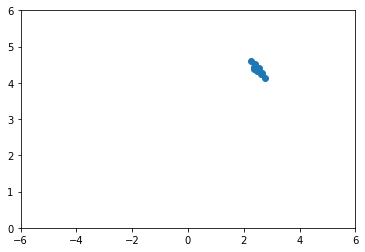

In [214]:
plt.figure()
plt.scatter(posX, posY)
axes = plt.gca()
axes.set_xlim([-6,6])
axes.set_ylim([0,6])

### Code to get predicted data to compare against labelled data

In [14]:
parsingMatFile = 'C:\\Users\\hasna\\Documents\\GitHub\\OccupancyDetection\\Data\\Experiment Data 2\\OnePersonWalkingLocation.mat'
tlvData = (loadmat(parsingMatFile))['tlvStream'][0]

predictedLabels = np.array([])

for tlvStream in tlvData:
    #parse
    posX, posY = liveParsing(tlvStream)
    try:
        if (posX == None).all():
            continue
    except AttributeError:
        continue
    #cluster
    yMean, xMean = CombinationClustering(posX, posY)
    predictedLabels = np.append(predictedLabels, len(yMean))
    

### Random Code

2.5150152274540494